In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import sem
from typing import Tuple

from behav_analysis import Participant_Behav
from data_functions import load_results


In [ ]:
par_num = "01"
par = Participant_Behav(par_num, adj_ts_markers=True)
behav_results = load_results(par.processed_data_dir, "n_back")
# behav_results

C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\805991980.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = behav_data.groupby("block").mean()[
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\805991980.py:59: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = behav_data.groupby("block").agg(


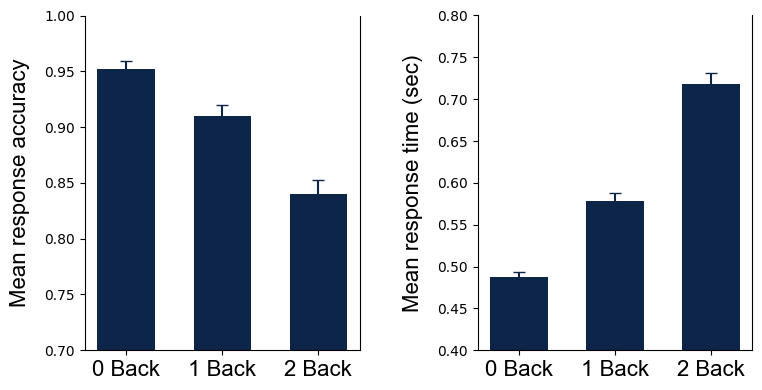

In [110]:
class Behav_Results:
    """
    This class contains attributes and functions for deriving and 
    plotting statistical results from processed behavioral data.
    """

    def __init__(self):
        self.dark_blue = (12 / 255, 37 / 255, 72 / 255)
        self.bar_width = 0.6
        self.capsize = 4
        self.label_fontsize = 16
        self.tick_fontsize = 14
        self.font = "Arial"
        self.par = Participant_Behav(1)

    def get_bar_plot_data(self, exp_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Group experiment data and calculate the mean response time and response accuracy.

        Args:
            exp_name (str): Experiment name.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, str]: Bar plot block data and SEM data.
        """
        behav_data = load_results(self.par.processed_data_dir, exp_name)

        if exp_name == "king_devick":
            self.group_var = "num_incorrect"
            self.group_label = "Mean incorrect responses"
            behav_data = behav_data.drop(
                behav_data[
                    (behav_data["participant"] == 15) & (behav_data["trial"] == 1)
                ].index
            )
            behav_data.loc[behav_data["participant"] == 15, ["trial"]] -= 1
            behav_data.loc[behav_data["participant"] == 15, "block"] = behav_data.loc[
                behav_data["participant"] == 15, "block"
            ].apply(lambda x: x[:-1] + str(int(x[-1]) - 1))

            block_data = behav_data.groupby("block").mean()[
                ["response_time", "num_incorrect"]
            ]
            block_sem = behav_data.groupby("block").agg(
                lambda x: sem(x, nan_policy="omit")
            )[["response_time", "num_incorrect"]]
            self.xtick_labels = list(block_data.index)

        elif (
            exp_name == "go_no_go"
            or exp_name == "n_back"
            or exp_name == "tower_of_london"
            or exp_name == "vSAT"
        ):
            self.group_var = "correct_response"
            self.group_label = "Mean response accuracy"
            block_data = behav_data.groupby("block").mean()[
                ["response_time", "correct_response"]
            ]
            block_sem = behav_data.groupby("block").agg(
                lambda x: sem(x, nan_policy="omit")
            )[["response_time", "correct_response"]]
            if exp_name == "tower_of_london":
                self.xtick_labels = ["Multi-move", "Zero-move"]
            elif exp_name == "go_no_go":
                self.xtick_labels = ["Go/no-go", "Go"]
            else:
                self.xtick_labels = [
                    block.replace("_", " ").title() for block in block_data.index
                ]
        return block_data, block_sem

    def create_bar_plot(self, exp_name: str) -> None:
        """
        Create a bar plot for a specified experiment.

        Args:
            exp_name (str): Experiment name.
        """

        def _format_ticks(ticks: list) -> list:
            """
            Format ticks to have 2 decimal places.

            Args:
                ticks (list): List of ticks.

            Returns:
                list: List of formatted ticks.
            """
            return [f"{tick:.2f}" for tick in ticks]

        block_data, block_sem = self.get_bar_plot_data(exp_name)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        fig.subplots_adjust(wspace=-0.5)

        # response accuracy
        ax1.bar(
            np.arange(len(block_data)),
            block_data[self.group_var],
            color=self.dark_blue,
            width=self.bar_width,
            yerr=block_sem[self.group_var],
            capsize=self.capsize,
            zorder=0,
            ecolor=self.dark_blue,
        )
        ax1.set_ylabel(
            self.group_label,
            color="black",
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax1.yaxis.set_label_coords(-0.2, 0.5)
        ax1.tick_params(axis="y", labelcolor="black")
        ax1.set_xticks(np.arange(len(block_data)))
        ax1.set_xticklabels(
            self.xtick_labels,
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax1.spines[["top"]].set_visible(False)

        # response time
        ax2.bar(
            np.arange(len(block_data)),
            block_data["response_time"],
            color=self.dark_blue,
            width=self.bar_width,
            yerr=block_sem["response_time"],
            capsize=self.capsize,
            zorder=0,
            ecolor=self.dark_blue,
        )
        ax2.set_ylabel(
            "Mean response time (sec)",
            color="black",
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax2.yaxis.set_label_coords(-0.2, 0.5)
        ax2.tick_params(axis="y", labelcolor="black")
        ax2.set_xticks(np.arange(len(block_data)))
        ax2.set_xticklabels(
            self.xtick_labels,
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax2.spines[["top"]].set_visible(False)

        # ticks and tick labels
        if exp_name == "go_no_go":
            acc_ylim = [0.9, 1]
            acc_yticks = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
            acc_ytick_labels = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
            resp_ylim = [0.4, 0.54]
            resp_yticks = [0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54]
            resp_ytick_labels = [0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54]
        elif exp_name == "king_devick":
            acc_ylim = [0, 0.4]
            acc_yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
            acc_ytick_labels = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
            resp_ylim = [14, 17]
            resp_yticks = [14, 14.5, 15, 15.5, 16, 16.5, 17]
            resp_ytick_labels = [14, 14.5, 15, 15.5, 16, 16.5, 17]
        elif exp_name == "n_back":
            acc_ylim = [0.7, 1.0]
            acc_yticks = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
            acc_ytick_labels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
            resp_ylim = [0.4, 0.8]
            resp_yticks = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
            resp_ytick_labels = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
        elif exp_name == "tower_of_london":
            acc_ylim = [0.8, 1]
            acc_yticks = [0.8, 0.85, 0.9, 0.95, 1]
            acc_ytick_labels = [0.8, 0.85, 0.9, 0.95, 1]
            resp_ylim = [0.6, 0.9]
            resp_yticks = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
            resp_ytick_labels = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
        elif exp_name == "vSAT":
            acc_ylim = [0.9, 0.94]
            acc_yticks = [0.9, 0.91, 0.92, 0.93, 0.94]
            acc_ytick_labels = [0.9, 0.91, 0.92, 0.93, 0.94]
            resp_ylim = [0.5, 0.58]
            resp_yticks = [0.5, 0.52, 0.54, 0.56, 0.58]
            resp_ytick_labels = [0.5, 0.52, 0.54, 0.56, 0.58]

        ax1.set_ylim(acc_ylim)
        ax2.set_ylim(resp_ylim)

        try:  # if ticks and tick labels are not specified, use defaults
            ax1.set_yticks(_format_ticks(acc_yticks))
            ax1.set_yticklabels(
                acc_ytick_labels,
                fontsize=self.tick_fontsize,
                fontname=self.font,
            )
            ax2.set_yticks(_format_ticks(resp_yticks))
            ax2.set_yticklabels(
                resp_ytick_labels,
                fontsize=self.tick_fontsize,
                fontname="Arial",
            )
        except:
            pass

        plt.tight_layout()
        plt.show()


# exp_name = "go_no_go"
# exp_name = "king_devick"
exp_name = "n_back"
# exp_name = "tower_of_london"
# exp_name = "vSAT"
BH = Behav_Results()
BH.create_bar_plot(exp_name)


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3674734975.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3674734975.py:9: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[


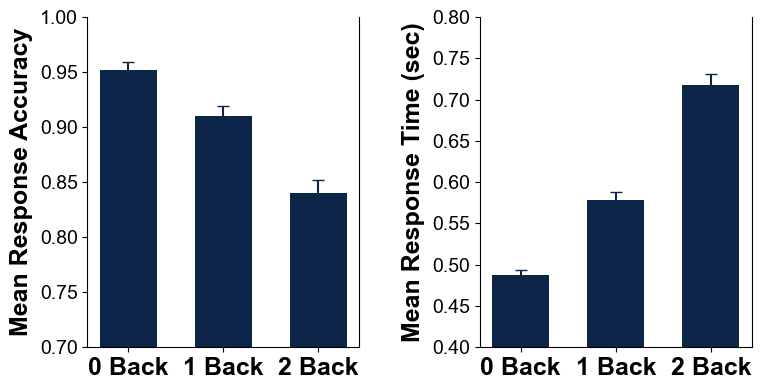

In [37]:
def format_yticks(x, pos):
    return f"{x:.2f}"
formatter = FuncFormatter(format_yticks)

df = behav_results

# Group the data by block and calculate the mean response time and mean correct response
block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[
    ["response_time", "correct_response"]
]

# Create a figure with two subplots
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
fig.subplots_adjust(wspace=-0.5)

# Plot the mean response time on the left y-axis
ax1.bar(
    np.arange(len(block_data)),
    block_data["response_time"],
    color=(12/255, 37/255, 72/255),
    width=0.6,
    yerr=block_sem["response_time"],
    capsize=4,
    zorder=0,
    ecolor=(12/255, 37/255, 72/255),
)
ax1.set_ylabel("Mean Response Time (sec)", color="black", fontsize=18, fontweight="bold", fontname="Arial")
ax1.yaxis.set_label_coords(-0.2, 0.5)
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_yticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
ax1.set_yticklabels([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8], fontsize=14, fontname="Arial")
ax1.set_ylim([0.4, 0.8])
ax1.set_xticks(np.arange(len(block_data)))
ax1.set_xticklabels([block.replace("_", " ").title() for block in block_data.index], fontsize=18, fontweight="bold", fontname="Arial")
ax1.yaxis.set_major_formatter(formatter)

# Plot the mean correct response on the right y-axis
ax2.bar(
    np.arange(len(block_data)),
    block_data["correct_response"],
    color=(12/255, 37/255, 72/255),
    width=0.6,
    yerr=block_sem["correct_response"],
    capsize=4,
    zorder=0,
    ecolor=(12/255, 37/255, 72/255),
)
ax2.set_ylabel("Mean Response Accuracy", color="black", fontsize=18, fontweight="bold", fontname="Arial")
ax2.yaxis.set_label_coords(-0.2, 0.5)
ax2.tick_params(axis="y", labelcolor="black")
ax2.set_yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
ax2.set_yticklabels([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], fontsize=14, fontname="Arial")
ax2.set_ylim([0.7, 1.0])
ax2.set_xticks(np.arange(len(block_data)))
ax2.set_xticklabels([block.replace("_", " ").title() for block in block_data.index], fontsize=18, fontweight="bold", fontname="Arial")
ax2.yaxis.set_major_formatter(formatter)

ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


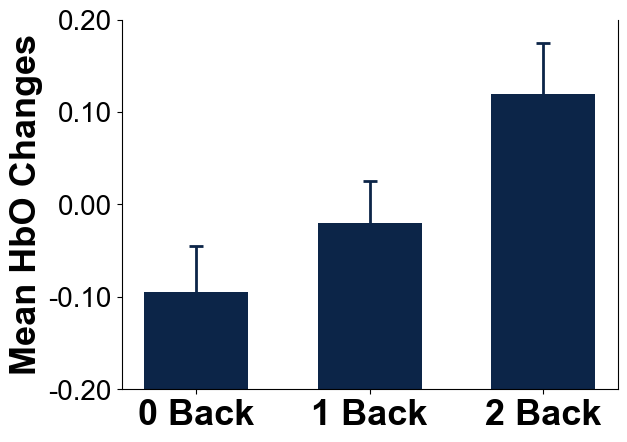

In [5]:
# 1076
def format_yticks(x, pos):
    return f"{x:.2f}"
formatter = FuncFormatter(format_yticks)

# Data
labels = ["0 Back", "1 Back", "2 Back"]
errors = [0.05, 0.045, 0.055]
bottom = -0.2
heights = [-0.095 - bottom, -0.02 - bottom, 0.12 - bottom]

# Plotting
x = np.arange(len(labels))
fig, ax = plt.subplots()
bar_plot = ax.bar(
    x,
    heights,
    width=0.6,
    color=(12 / 255, 37 / 255, 72 / 255),
    bottom=bottom,
    yerr=errors,
    align="center",
    ecolor=(12 / 255, 37 / 255, 72 / 255),
    # capsize=8,
    error_kw=dict(lw=2, capsize=5, capthick=2)
)
ax.set_ylim(bottom, 0.2)

# Labels and axes
ax.spines[['top']].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=26, fontweight="bold", fontname="Arial")
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticklabels([-0.2, -0.1, 0, 0.1, 0.2], fontsize=20, fontname="Arial")
ax.set_ylabel("Mean HbO Changes", fontsize=26, fontweight="bold", fontname="Arial")
ax.yaxis.set_major_formatter(formatter)
# ax.set_title('Bar Plot with Error Bars')

# Show the plot
plt.show()


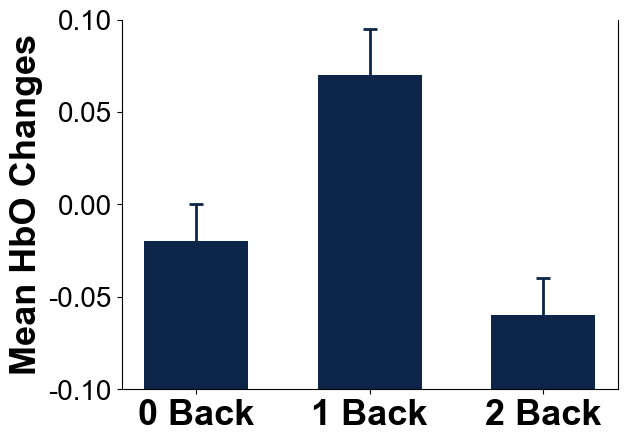

In [6]:
# 1548 V2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_yticks(x, pos):
    return f"{x:.2f}"
formatter = FuncFormatter(format_yticks)

# Data
labels = ["0 Back", "1 Back", "2 Back"]
errors = [0.02, 0.025, 0.02]
bottom = -0.1
heights = [-0.02 - bottom, 0.07 - bottom, -0.06 - bottom]

# Plotting
x = np.arange(len(labels))
fig, ax = plt.subplots()
bar_plot = ax.bar(
    x,
    heights,
    width=0.6,
    color=(12 / 255, 37 / 255, 72 / 255),
    bottom=bottom,
    yerr=errors,
    align="center",
    ecolor=(12 / 255, 37 / 255, 72 / 255),
    # capsize=8,
    error_kw=dict(lw=2, capsize=5, capthick=2)
)
ax.set_ylim(bottom, 0.1)

# Labels and axes
ax.spines[['top']].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=26, fontweight="bold", fontname="Arial")
ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
ax.set_yticklabels([-0.1, -0.05, 0, 0.05, 0.1], fontsize=20, fontname="Arial")
ax.set_ylabel("Mean HbO Changes", fontsize=26, fontweight="bold", fontname="Arial")
ax.yaxis.set_major_formatter(formatter)
# ax.set_title('Bar Plot with Error Bars')

# Show the plot
plt.show()


In [7]:
kd_results = load_results(par.processed_data_dir, "king_devick")
kd_results = kd_results.drop(kd_results[(kd_results["participant"] == 15) & (kd_results["trial"] == 1)].index)
kd_results.loc[kd_results["participant"] == 15, ["trial"]] -= 1
kd_results.loc[kd_results["participant"] == 15, "block"] = kd_results.loc[kd_results["participant"] == 15, "block"].apply(lambda x: x[:-1] + str(int(x[-1])-1))
kd_results[0:5]

,participant,date,time,sex,age,native_language,verbal_english_proficiency,written_english_proficiency,educational_history,hours_of_sleep,...,num_caffeinated_beverages,handedness_LQ,handedness_decile,mental_wellbeing_score,trial,block,stim_start,stim_end,response_time,num_incorrect
0,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1.0,62.5,3.0,3.79,1,card_1,1.655321e+09,1.655321e+09,15.563977,0
1,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1.0,62.5,3.0,3.79,2,card_2,1.655321e+09,1.655321e+09,15.689666,1
2,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1.0,62.5,3.0,3.79,3,card_3,1.655321e+09,1.655321e+09,16.505372,0
3,2,2022-06-17 00:00:00,13:30:00,M,26,Turkish,7,8,Master's (BME),8.0,...,0.0,73.3,4.0,2.71,1,card_1,1.655488e+09,1.655488e+09,18.515140,0
4,2,2022-06-17 00:00:00,13:30:00,M,26,Turkish,7,8,Master's (BME),8.0,...,0.0,73.3,4.0,2.71,2,card_2,1.655488e+09,1.655488e+09,17.780637,0


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\4215543855.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = df.groupby("block").mean()[["response_time", "num_incorrect"]]
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\4215543855.py:6: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[


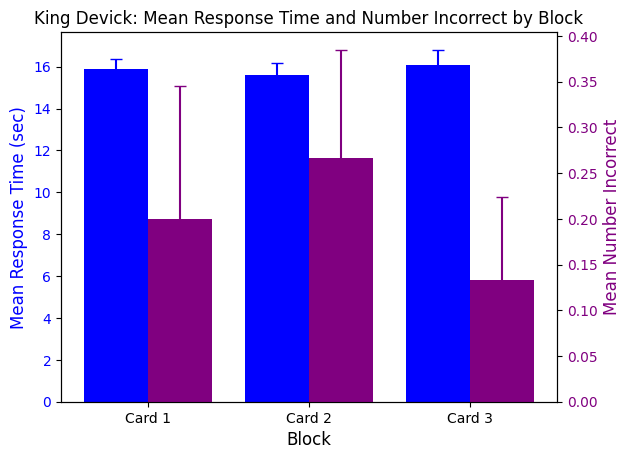

In [8]:
# Load the data
df = kd_results

# Group the data by block and calculate the mean response time and mean correct response
block_data = df.groupby("block").mean()[["response_time", "num_incorrect"]]
block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[
    ["response_time", "num_incorrect"]
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot the mean response time on the left y-axis
ax1.bar(
    np.arange(len(block_data)),
    block_data["response_time"],
    color="blue",
    width=0.4,
    yerr=block_sem["response_time"],
    capsize=4,
    zorder=0,
    ecolor="blue",
)
ax1.set_xlabel("Block", fontsize=12)
ax1.set_ylabel("Mean Response Time (sec)", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
# ax1.set_ylim([0.4, 0.8])

# Create a second y-axis for the mean correct response
ax2 = ax1.twinx()
ax2.bar(
    np.arange(len(block_data)) + 0.4,
    block_data["num_incorrect"],
    color="purple",
    width=0.4,
    yerr=block_sem["num_incorrect"],
    capsize=4,
    zorder=0,
    ecolor="purple",
)
ax2.set_ylabel("Mean Number Incorrect", color="purple", fontsize=12)
ax2.tick_params(axis="y", labelcolor="purple")
# ax2.set_ylim([0.7, 1.0])

# Set the x-axis tick labels to the block names
ax1.set_xticks(np.arange(len(block_data)) + 0.2)
ax1.set_xticklabels([block.replace("_", " ").title() for block in block_data.index])

# Add a title and show the plot
plt.title("King Devick: Mean Response Time and Number Incorrect by Block")
plt.show()

In [9]:
vsat_results = load_results(par.processed_data_dir, "vSAT")
vsat_results[0:5]

,participant,date,time,sex,age,native_language,verbal_english_proficiency,written_english_proficiency,educational_history,hours_of_sleep,...,inter_stim_time,position,inter_stim_start,inter_stim_end,stim_start,stim_end,correct_response,response_time,feedback_sound_start,feedback_sound_end
0,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1.0,center,1.655321e+09,1.655321e+09,1.655321e+09,1.655321e+09,0.0,NaN,1.655321e+09,1.655321e+09
1,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,2.0,center,1.655321e+09,1.655321e+09,1.655321e+09,1.655321e+09,1.0,0.643614,1.655321e+09,1.655321e+09
2,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,2.0,center,1.655321e+09,1.655321e+09,1.655321e+09,1.655321e+09,1.0,0.754257,1.655321e+09,1.655321e+09
3,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1.0,center,1.655321e+09,1.655321e+09,1.655321e+09,1.655321e+09,1.0,0.692760,1.655321e+09,1.655321e+09
4,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,2.0,center,1.655321e+09,1.655321e+09,1.655321e+09,1.655321e+09,1.0,0.321468,1.655321e+09,1.655321e+09


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\389535828.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\389535828.py:6: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history', 'position'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[


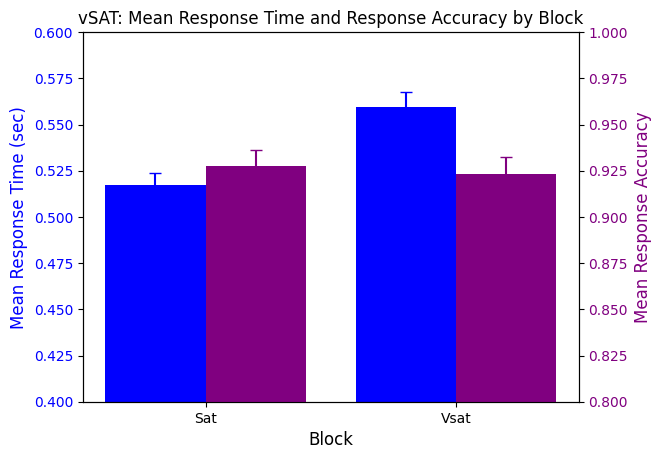

In [75]:
# Load the data
df = vsat_results

# Group the data by block and calculate the mean response time and mean correct response
block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[
    ["response_time", "correct_response"]
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot the mean response time on the left y-axis
ax1.bar(
    np.arange(len(block_data)),
    block_data["response_time"],
    color="blue",
    width=0.4,
    yerr=block_sem["response_time"],
    capsize=4,
    zorder=0,
    ecolor="blue",
)
ax1.set_xlabel("Block", fontsize=12)
ax1.set_ylabel("Mean Response Time (sec)", color="blue", fontsize=12)
ax1.set_ylim([0.4, 0.6])
ax1.tick_params(axis="y", labelcolor="blue")
# ax1.set_ylim([0.4, 0.8])

# Create a second y-axis for the mean correct response
ax2 = ax1.twinx()
ax2.bar(
    np.arange(len(block_data)) + 0.4,
    block_data["correct_response"],
    color="purple",
    width=0.4,
    yerr=block_sem["correct_response"],
    capsize=4,
    zorder=0,
    ecolor="purple",
)
ax2.set_ylabel("Mean Response Accuracy", color="purple", fontsize=12)
ax2.set_ylim([0.8, 1.0])
ax2.tick_params(axis="y", labelcolor="purple")
# ax2.set_ylim([0.7, 1.0])

# Set the x-axis tick labels to the block names
ax1.set_xticks(np.arange(len(block_data)) + 0.2)
ax1.set_xticklabels([block.replace("_", " ").title() for block in block_data.index])

# Add a title and show the plot
plt.title("vSAT: Mean Response Time and Response Accuracy by Block")
plt.show()

In [11]:
tol_results = load_results(par.processed_data_dir, "tower_of_london")
tol_results[0:5]

,participant,date,time,sex,age,native_language,verbal_english_proficiency,written_english_proficiency,educational_history,hours_of_sleep,...,trial,block,match,stim,stim_start,stim_end,response_start,response_end,correct_response,response_time
0,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,MM,0.0,not_two_move,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,0.0,0.790830
1,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,MM,1.0,two_move,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.632662
2,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,MM,1.0,two_move,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.856727
3,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,MM,0.0,not_two_move,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.584455
4,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,MM,1.0,two_move,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.632280


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3348932854.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3348932854.py:6: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history', 'stim'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[


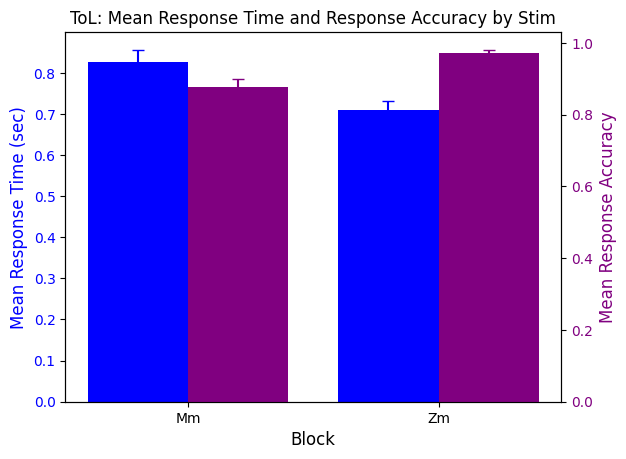

In [79]:
# Load the data
df = tol_results

# Group the data by block and calculate the mean response time and mean correct response
block_data = df.groupby("block").mean()[["response_time", "correct_response"]]
block_sem = df.groupby("block").agg(lambda x: sem(x, nan_policy="omit"))[
    ["response_time", "correct_response"]
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot the mean response time on the left y-axis
ax1.bar(
    np.arange(len(block_data)),
    block_data["response_time"],
    color="blue",
    width=0.4,
    yerr=block_sem["response_time"],
    capsize=4,
    zorder=0,
    ecolor="blue",
)
ax1.set_xlabel("Block", fontsize=12)
ax1.set_ylabel("Mean Response Time (sec)", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
# ax1.set_ylim([0.4, 0.8])

# Create a second y-axis for the mean correct response
ax2 = ax1.twinx()
ax2.bar(
    np.arange(len(block_data)) + 0.4,
    block_data["correct_response"],
    color="purple",
    width=0.4,
    yerr=block_sem["correct_response"],
    capsize=4,
    zorder=0,
    ecolor="purple",
)
ax2.set_ylabel("Mean Response Accuracy", color="purple", fontsize=12)
ax2.tick_params(axis="y", labelcolor="purple")
# ax2.set_ylim([0.7, 1.0])

# Set the x-axis tick labels to the block names
ax1.set_xticks(np.arange(len(block_data)) + 0.2)
ax1.set_xticklabels([block.replace("_", " ").title() for block in block_data.index])

# Add a title and show the plot
plt.title("ToL: Mean Response Time and Response Accuracy by Stim")
plt.show()

In [13]:
gng_results = load_results(par.processed_data_dir, "go_no_go")
gng_results[0:5]

,participant,date,time,sex,age,native_language,verbal_english_proficiency,written_english_proficiency,educational_history,hours_of_sleep,...,trial,block,match,stim,inter_stim_start,inter_stim_end,stim_start,stim_end,correct_response,response_time
0,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.464158
1,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.519317
2,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.391665
3,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.369224
4,1,2022-06-15 00:00:00,14:30:00,M,25,English,10,10,Master's (BME),8.0,...,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.346970


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\1263630958.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = df.groupby("stim").mean()[["response_time", "correct_response"]]
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\1263630958.py:6: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history', 'block'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = df.groupby("stim").agg(lambda x: sem(x, nan_policy="omit"))[


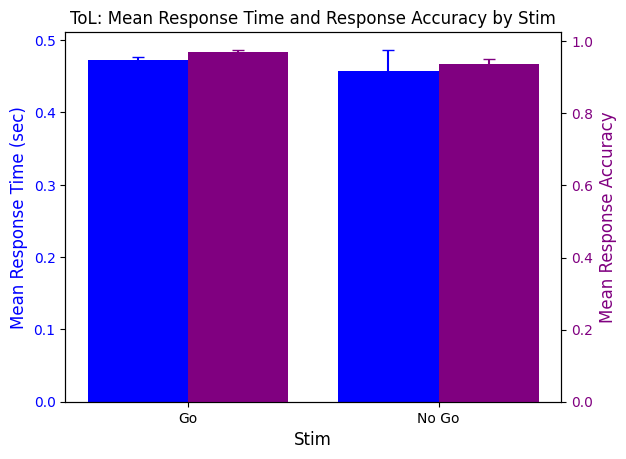

In [97]:
# Load the data
df = gng_results

# Group the data by block and calculate the mean response time and mean correct response
block_data = df.groupby("stim").mean()[["response_time", "correct_response"]]
block_sem = df.groupby("stim").agg(lambda x: sem(x, nan_policy="omit"))[
    ["response_time", "correct_response"]
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot the mean response time on the left y-axis
ax1.bar(
    np.arange(len(block_data)),
    block_data["response_time"],
    color="blue",
    width=0.4,
    yerr=block_sem["response_time"],
    capsize=4,
    zorder=0,
    ecolor="blue",
)
ax1.set_xlabel("Stim", fontsize=12)
ax1.set_ylabel("Mean Response Time (sec)", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
# ax1.set_ylim([0.4, 0.8])

# Create a second y-axis for the mean correct response
ax2 = ax1.twinx()
ax2.bar(
    np.arange(len(block_data)) + 0.4,
    block_data["correct_response"],
    color="purple",
    width=0.4,
    yerr=block_sem["correct_response"],
    capsize=4,
    zorder=0,
    ecolor="purple",
)
ax2.set_ylabel("Mean Response Accuracy", color="purple", fontsize=12)
ax2.tick_params(axis="y", labelcolor="purple")
# ax2.set_ylim([0.7, 1.0])

# Set the x-axis tick labels to the block names
ax1.set_xticks(np.arange(len(block_data)) + 0.2)
ax1.set_xticklabels([block.replace("_", " ").title() for block in block_data.index])

# Add a title and show the plot
plt.title("ToL: Mean Response Time and Response Accuracy by Stim")
plt.show()

In [15]:
def results_bar_plot(
    df: pd.DataFrame,
    groupby: str,
    cols: list,
    x_label: str,
    y_left: tuple,
    y_right: tuple,
    title: str,
    lims: bool = False,
) -> None:

    y_label_left = y_left[0]
    y_lim_left = y_left[1]
    y_label_right = y_right[0]
    y_lim_right = y_right[1]

    group_data = df.groupby(groupby).mean()[cols]
    group_sem = df.groupby(groupby).agg(lambda x: sem(x, nan_policy="omit"))[cols]

    # Create a figure with two subplots
    fig, ax1 = plt.subplots()

    # Plot the mean response time on the left y-axis
    ax1.bar(
        np.arange(len(group_data)),
        group_data[cols[0]],
        color="blue",
        width=0.4,
        yerr=group_sem[cols[0]],
        capsize=4,
        zorder=0,
        ecolor="blue",
    )
    ax1.set_xlabel(x_label, fontsize=12)
    ax1.set_ylabel(y_label_left, color="blue", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="blue")
    if lims:
        ax1.set_ylim(y_lim_left)

    # Create a second y-axis for the mean correct response
    ax2 = ax1.twinx()
    ax2.bar(
        np.arange(len(group_data)) + 0.4,
        group_data[cols[1]],
        color="purple",
        width=0.4,
        yerr=group_sem[cols[1]],
        capsize=4,
        zorder=0,
        ecolor="purple",
    )
    ax2.set_ylabel(y_label_right, color="purple", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="purple")
    if lims:
        ax2.set_ylim(y_lim_right)

    # Set the x-axis tick labels to the block names
    ax1.set_xticks(np.arange(len(group_data)) + 0.2)
    ax1.set_xticklabels([block.replace("_", " ").title() for block in group_data.index])

    # Add a title and show the plot
    plt.title(title)
    plt.show()
